<h1 align="center">Machine Learning and Vision Lab</h1>
<h4 align="center">Dr. Mohammadzadeh</h4>
<h4 align="center">Sharif University of Technology, Fall 2023</h4>
<h4 align="center">Amir Hossein Yari - 99102507</h4>
<h4 align="center">Lab 3 - Fisher LDA Classification</h4>

In [3]:
# Import required package
import os
import random
import cv2
import numpy as np
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier

In [4]:
# Function to load images from a folder
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder, filename))
        if img is not None:
            images.append(img)
    return images

# Load images from the "happy" and "surprise" folders
happy_images = load_images_from_folder("happy")
surprise_images = load_images_from_folder("surprise")

In [5]:
# Shuffle the images to randomize the selection
random.shuffle(happy_images)
random.shuffle(surprise_images)

# Select 50 images for training from each category
num_train_images = 50
happy_train_images = happy_images[:num_train_images]
surprise_train_images = surprise_images[:num_train_images]

# Use the remaining images as the test set
happy_test_images = happy_images[num_train_images:]
surprise_test_images = surprise_images[num_train_images:]

# Combine the train and test sets
train_images = happy_train_images + surprise_train_images
test_images = happy_test_images + surprise_test_images

# Convert the images to grayscale and flatten them
train_data = [cv2.cvtColor(img, cv2.COLOR_BGR2GRAY).flatten() for img in train_images]
test_data = [cv2.cvtColor(img, cv2.COLOR_BGR2GRAY).flatten() for img in test_images]

In [6]:
# Perform PCA to reduce the dimension to 50
n_components = 50
pca = PCA(n_components=n_components)

# Fit and transform the PCA on the training data
train_pca = pca.fit_transform(train_data)

# Transform the test data using the same PCA
test_pca = pca.transform(test_data)

In [7]:
# Define the class labels for the training data
class_labels_train = [0] * len(happy_train_images) + [1] * len(surprise_train_images)  # 0 for "happy," 1 for "surprise"

# Define the class labels for the training data
class_labels_test = [0] * len(happy_test_images) + [1] * len(surprise_test_images)  # 0 for "happy," 1 for "surprise"

# Initialize and fit Linear Discriminant Analysis (LDA)
lda = LinearDiscriminantAnalysis(n_components=1)
lda.fit(train_pca, class_labels_train)

# Get the Fisher eigenvectors
fisher_eigenvectors = lda.scalings_

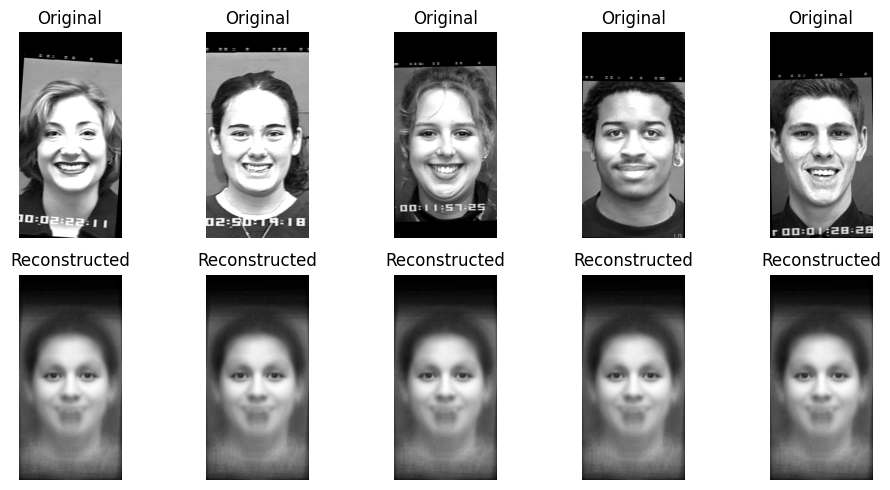

In [8]:
# Reconstruct the images in pixel space
reconstructed_images = lda.transform(train_pca)
reconstructed_images = np.dot(reconstructed_images, fisher_eigenvectors.T)
reconstructed_images = pca.inverse_transform(reconstructed_images)
# reconstructed_images = pca.inverse_transform(fisher_eigenvectors.T)

# Reshape the reconstructed images to their original dimensions
reconstructed_images = reconstructed_images.reshape(-1, 600, 300)

# Plot the reconstructed images
plt.figure(figsize=(10, 5))
for i in range(5):  # Change the range to plot more images
    plt.subplot(2, 5, i + 1)
    plt.imshow(train_images[i], cmap='gray')
    plt.title("Original")
    plt.axis("off")

    plt.subplot(2, 5, i + 6)
    plt.imshow(reconstructed_images[i], cmap='gray')
    plt.title("Reconstructed")
    plt.axis("off")

plt.tight_layout()
plt.show()


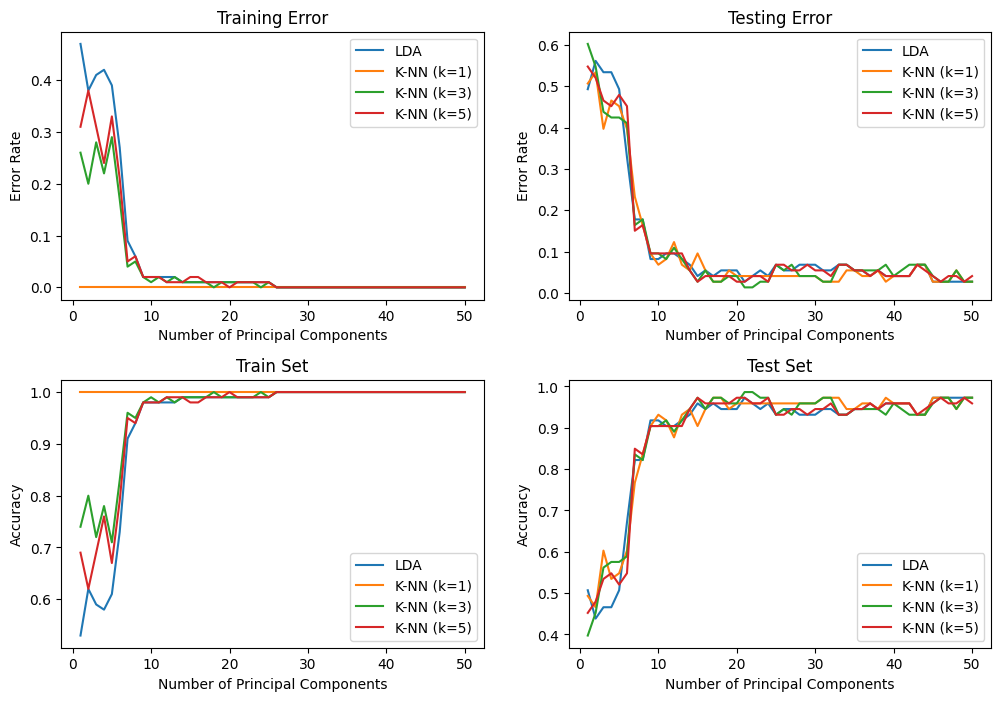

In [9]:
# Initialize lists to store error rates
lda_train_errors = []
lda_test_errors = []
knn_train_errors = {k: [] for k in [1, 3, 5]}
knn_test_errors = {k: [] for k in [1, 3, 5]}

# Initialize lists to store accuracy
lda_train_acuracy = []
lda_test_acuracy = []
knn_train_acuracy = {k: [] for k in [1, 3, 5]}
knn_test_acuracy = {k: [] for k in [1, 3, 5]}

# Loop through different numbers of principal components (1 to 50)
for n_components in range(1, 51):
    # Perform PCA
    pca = PCA(n_components=n_components)
    train_pca = pca.fit_transform(train_data)
    test_pca = pca.transform(test_data)

    # Perform LDA
    lda = LinearDiscriminantAnalysis(n_components=1)
    lda.fit(train_pca, class_labels_train)
    train_lda = lda.transform(train_pca)
    test_lda = lda.transform(test_pca)

    # Train K-NN models for different values of k
    for k in [1, 3, 5]:
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(train_lda, class_labels_train)
        train_pred = knn.predict(train_lda)
        test_pred = knn.predict(test_lda)

        # Calculate and store error rates
        knn_train_errors[k].append(1 - accuracy_score(class_labels_train, train_pred))
        knn_test_errors[k].append(1 - accuracy_score(class_labels_test, test_pred))
        knn_train_acuracy[k].append(accuracy_score(class_labels_train, train_pred))
        knn_test_acuracy[k].append(accuracy_score(class_labels_test, test_pred))
    lda_train_errors.append(1 - accuracy_score(class_labels_train, lda.predict(train_pca)))
    lda_test_errors.append(1 - accuracy_score(class_labels_test, lda.predict(test_pca)))
    lda_train_acuracy.append(accuracy_score(class_labels_train, lda.predict(train_pca)))
    lda_test_acuracy.append(accuracy_score(class_labels_test, lda.predict(test_pca)))

# Create subplots for training and testing errors
plt.figure(figsize=(12, 8))
plt.subplots_adjust(hspace=0.3)

# Training errors
plt.subplot(2, 2, 1)
plt.plot(range(1, 51), lda_train_errors, label='LDA')
for k in [1, 3, 5]:
    plt.plot(range(1, 51), knn_train_errors[k], label=f'K-NN (k={k})')
plt.title('Training Error')
plt.xlabel('Number of Principal Components')
plt.ylabel('Error Rate')
plt.legend()

# Testing errors
plt.subplot(2, 2, 2)
plt.plot(range(1, 51), lda_test_errors, label='LDA')
for k in [1, 3, 5]:
    plt.plot(range(1, 51), knn_test_errors[k], label=f'K-NN (k={k})')
plt.title('Testing Error')
plt.xlabel('Number of Principal Components')
plt.ylabel('Error Rate')
plt.legend()

# Training accuracy
plt.subplot(2, 2, 3)
plt.plot(range(1, 51), lda_train_acuracy, label='LDA')
for k in [1, 3, 5]:
    plt.plot(range(1, 51), knn_train_acuracy[k], label=f'K-NN (k={k})')
plt.title('Train Set')
plt.xlabel('Number of Principal Components')
plt.ylabel('Accuracy')
plt.legend()

# Testing accuracy
plt.subplot(2, 2, 4)
plt.plot(range(1, 51), lda_test_acuracy, label='LDA')
for k in [1, 3, 5]:
    plt.plot(range(1, 51), knn_test_acuracy[k], label=f'K-NN (k={k})')
plt.title('Test Set')
plt.xlabel('Number of Principal Components')
plt.ylabel('Accuracy')
plt.legend()

plt.show()
